##  
##  
## Introduction

Objective is to create a regression tree that predicts whether a tax return will fund from the IRS.  
The explanatory variable is a binary flag, 'Funded', with values of 1 (funded) and 0 (unfunded).  
The independent variables are several masked binary Federal form flags (1 means yes the form is present).  
Also have some other categorical and numeric variables to evaluate.



##   
##    
## Importing the data set and taking a peak   










In [48]:
#Import all the needed libraries
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 4000


In [4]:
#Import the dataset

data_path = Path('Sample Output.csv')
data = pd.read_csv(data_path)


In [5]:
#Take a peak at the data

data.head()

,Sort_ID,InvoiceID,Date_1,Date_2,Date_3,Field_20,Field_4,Field_9,Field_10,Field_11,...,FedForm_144,FedForm_145,FedForm_146,FedForm_147,FedForm_148,FedForm_149,FedForm_150,FedForm_151,FedForm_152,FedForm_153
0,AEB8553A-B4FB-48C9-A98F-000004FE5C78,45004853,20180210,20180210,20180210,1988,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,9B5A36AA-3C3D-43CA-A9A3-0000112FF3FA,44327950,20180118,20180124,20180129,1995,3,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,B886E7BA-E291-4758-A6B6-0000397078D7,44579539,20180129,20180129,20180129,1990,2,2,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A24CA56B-430B-4F14-8692-00004D9E8F2D,44175456,20180103,20180130,20180130,1992,3,5,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5FF6DDE5-E3D1-4C0C-99D2-000053869E3F,44747837,20180202,20180202,20180202,1981,3,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#Pull the size of the data set

data.shape
#177 columns of data, 100,000 rows

(100000, 177)

In [16]:
#Check for any null values

print(data.isnull().sum().sort_values(ascending = True))




Sort_ID        0
FedForm_89     0
FedForm_90     0
FedForm_91     0
FedForm_92     0
FedForm_93     0
FedForm_94     0
FedForm_95     0
FedForm_96     0
FedForm_88     0
FedForm_97     0
FedForm_99     0
FedForm_100    0
FedForm_101    0
FedForm_102    0
FedForm_103    0
FedForm_104    0
FedForm_105    0
FedForm_106    0
FedForm_98     0
FedForm_107    0
FedForm_87     0
FedForm_85     0
FedForm_67     0
FedForm_68     0
FedForm_69     0
FedForm_70     0
FedForm_71     0
FedForm_72     0
FedForm_73     0
FedForm_74     0
FedForm_86     0
FedForm_75     0
FedForm_77     0
FedForm_78     0
FedForm_79     0
FedForm_80     0
FedForm_81     0
FedForm_82     0
FedForm_83     0
FedForm_84     0
FedForm_76     0
FedForm_108    0
FedForm_109    0
FedForm_110    0
FedForm_134    0
FedForm_135    0
FedForm_136    0
FedForm_137    0
FedForm_138    0
FedForm_139    0
FedForm_140    0
FedForm_141    0
FedForm_133    0
FedForm_142    0
FedForm_144    0
FedForm_145    0
FedForm_146    0
FedForm_147   

No null values in the entire data set, clean data


##   
##   
## Look into forms data  

In [22]:
#Calculate total sums for the form counts to find the largest forms
totalcounts = data.sum()

In [30]:
#Pick out the 30 largest form counts to include in models
totalcounts


Sort_ID        AEB8553A-B4FB-48C9-A98F-000004FE5C789B5A36AA-3...
InvoiceID                                          4478157292931
Date_1                                             2017898065135
Date_2                                             2018019324734
Date_3                                             2016541591915
Field_20                                               197866085
Field_4                                                   256056
Field_9                                                   247588
Field_10                                                   21661
Field_11                                                   99336
Field_12                                                  133569
Field_13                                                    2475
Field_14                                                    1499
Field_6                                              2.62088e+09
Field_7                                              4.06144e+08
Field_18                 

Forms of interest: 


'FedForm_106', 'FedForm_5', 'FedForm_21', 'FedForm_140', 'FedForm_78', 'FedForm_107', 'FedForm_3', 'FedForm_13',
'FedForm_22', 'FedForm_105', 'FedForm_102', 'FedForm_91', 'FedForm_132', 'FedForm_8', 'FedForm_146', 'FedForm_152',
'FedForm_26', 'FedForm_129', 'FedForm_133', 'FedForm_27', 'FedForm_121', 'FedForm_126', 'FedForm_111', 'FedForm_28',
'FedForm_90', 'FedForm_6', 'FedForm_113', 'FedForm_124', 'FedForm_93', 'FedForm_43'



In [44]:
#Create subset of the data with just the 30 top forms, as well as the funding data (the variable we are trying to predict)

formsdata = ( 
                data.loc[:, 
                           ['Funded',
                            'FedForm_106', 'FedForm_5', 'FedForm_21', 'FedForm_140', 'FedForm_78', 
                            'FedForm_107', 'FedForm_3', 'FedForm_13', 'FedForm_22', 'FedForm_105', 
                            'FedForm_102', 'FedForm_91', 'FedForm_132', 'FedForm_8', 'FedForm_146', 
                            'FedForm_152', 'FedForm_26', 'FedForm_129', 'FedForm_133', 'FedForm_27',
                            'FedForm_121', 'FedForm_126', 'FedForm_111', 'FedForm_28', 'FedForm_90', 
                            'FedForm_6', 'FedForm_113', 'FedForm_124', 'FedForm_93', 'FedForm_43'               
                           ]
                        ] )

In [45]:
formsdata.head()

,Funded,FedForm_106,FedForm_5,FedForm_21,FedForm_140,FedForm_78,FedForm_107,FedForm_3,FedForm_13,FedForm_22,...,FedForm_121,FedForm_126,FedForm_111,FedForm_28,FedForm_90,FedForm_6,FedForm_113,FedForm_124,FedForm_93,FedForm_43
0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


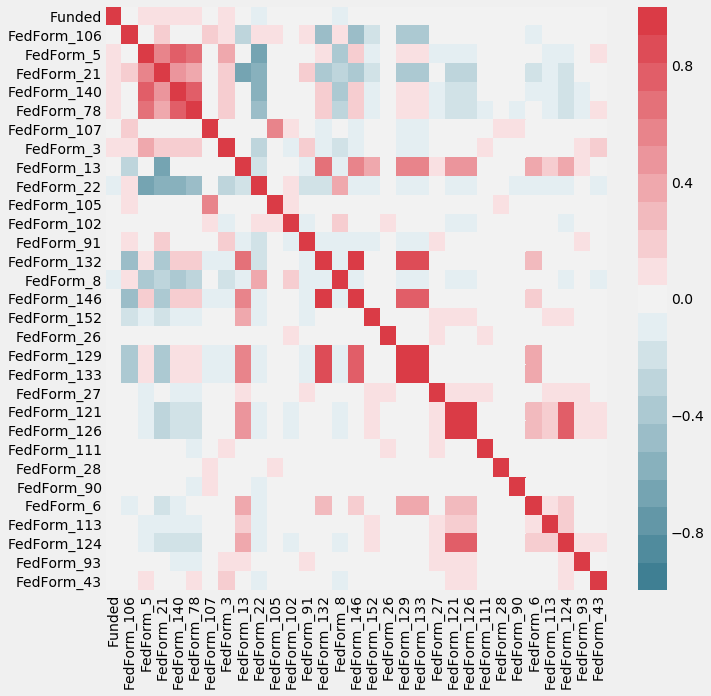

In [52]:
#Correlation matrix for forms data 
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(formsdata.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(h_neg=220, h_pos=10, n=21))

In [ ]:
Funded only weekly correlated with 5, 21, 140, 78, 3, and negative with 8

##   
##    
## Look at the categorical variables

In [86]:
data.loc[:,'Field_4'].value_counts()

3    60014
2    36028
1     3958
Name: Field_4, dtype: int64

In [80]:
data.groupby('Field_4')['Funded'].mean()

Field_4
1    0.891359
2    0.862995
3    0.956810
Name: Funded, dtype: float64

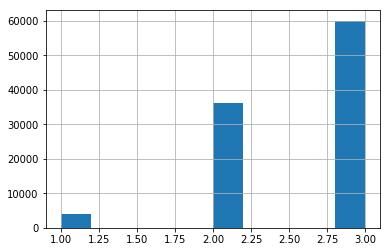

In [32]:
ax = data.loc[:,'Field_4'].hist()

Values of 3 have higher funding rates than values of 1 and 2   
Somewhat lopsided distribution of values, but still sizeable populations (4k being smallest)
##       

In [85]:
data.loc[:,'Field_9'].value_counts()

1    48771
5    31738
2    18435
3      947
4      104
0        5
Name: Field_9, dtype: int64

In [77]:
data.groupby('Field_9')['Funded'].mean()

Field_9
0    1.000000
1    0.941748
2    0.936588
3    0.871172
4    0.961538
5    0.879577
Name: Funded, dtype: float64

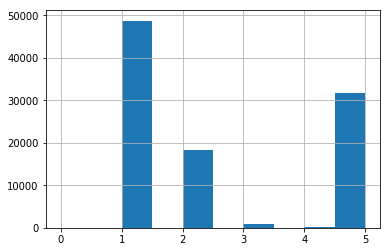

In [34]:
ax = data.loc[:,'Field_9'].hist()

Very low value counts for values of 0/3/4, need to revisit raw data and perhaps group data together  
Funding rates vary dramatically across different values
##  


In [36]:
data.loc[:,'Field_11'].value_counts()

1    98136
0     1264
2      600
Name: Field_11, dtype: int64

In [87]:
data.groupby('Field_11')['Funded'].mean()

Field_11
0    0.540348
1    0.930933
2    0.001667
Name: Funded, dtype: float64

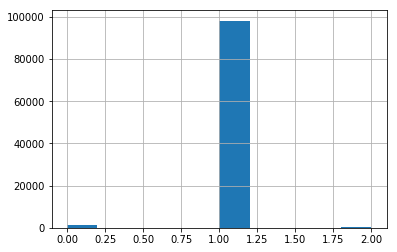

In [37]:
ax = data.loc[:,'Field_11'].hist()

Given how unbalanced field is, might need to throw out field
##   


In [88]:
data.loc[:,'Field_5'].value_counts()

3     43893
2     42030
9     13449
4       488
10      108
1        28
7         2
6         2
Name: Field_5, dtype: int64

In [89]:
data.groupby('Field_5')['Funded'].mean()

Field_5
1     0.000000
2     0.907471
3     0.944661
4     0.903689
6     0.000000
7     0.000000
9     0.884973
10    0.870370
Name: Funded, dtype: float64

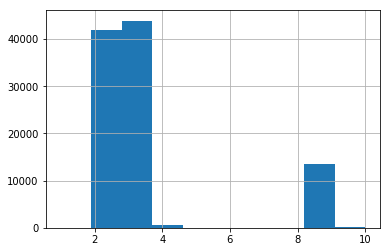

In [39]:
ax = data.loc[:,'Field_5'].hist()

Wide dispersion in responses, need to revisit raw data to see if better way to group data
##  


In [26]:
data.loc[:,'Field_15'].value_counts()

3    64857
2    34940
1      203
Name: Field_15, dtype: int64

In [90]:
data.groupby('Field_15')['Funded'].mean()

Field_15
1    0.911330
2    0.910675
3    0.925698
Name: Funded, dtype: float64

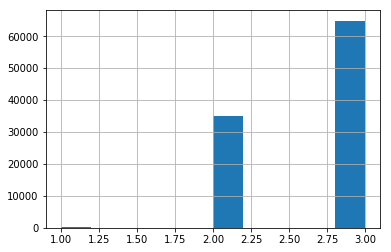

In [40]:
ax = data.loc[:,'Field_15'].hist()

Very low value count for outcome 1, need to validate against raw data to make sure accurate   
200 is probably too small for an accurate reference group as dummy variable  
Pretty consistent funding rates across all values
##  

##   
##    
## Look at the numeric variables




In [62]:
#Create numeric dataset
numericdata = data.loc[:,['Funded','Field_12','Field_6','Field_7']]


In [63]:
numericdata.head()

,Funded,Field_12,Field_6,Field_7
0,1,2,24702.0,6527.0
1,1,2,8432.0,4342.0
2,1,2,25589.0,10260.0
3,1,0,39856.0,1614.0
4,1,2,24302.0,6057.0


In [64]:
numericdata.describe()

,Funded,Field_12,Field_6,Field_7
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.920420,1.335690,26208.836660,4061.440230
std,0.270643,1.202405,21151.171942,2795.331631
min,0.000000,0.000000,-113582.000000,-25343.000000
25%,1.000000,0.000000,12792.750000,1372.000000
50%,1.000000,1.000000,20756.500000,3848.000000
75%,1.000000,2.000000,32602.500000,6021.250000
max,1.000000,12.000000,413321.000000,42821.000000


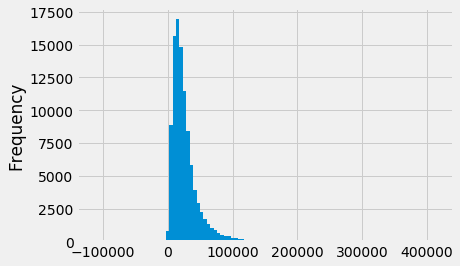

In [58]:
ax = data.loc[:, 'Field_6'].plot(kind='hist', bins=100)


This field demonstrates a rightward skew, consistent with the describe table above (median is 21,000 while mean is 26,000)

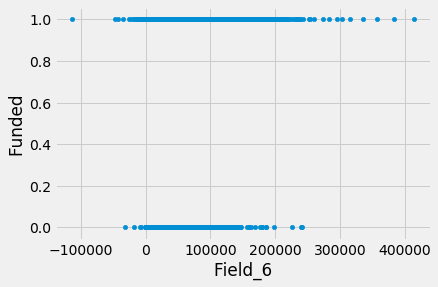

In [59]:
data.plot(kind='scatter', x='Field_6', y='Funded');

Not seeing a clear relationship between funding and Field_6, although the funded demonstrate a wider range


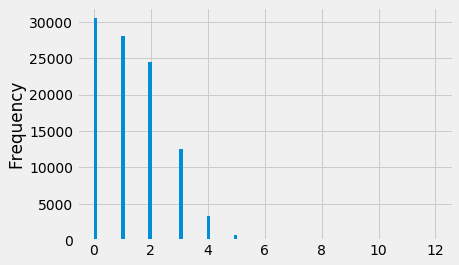

In [65]:
ax = data.loc[:, 'Field_12'].plot(kind='hist', bins=100)



One sided distribution (cannot go negative)

Mean slightly higher than median (1.33 vs 1), supports slight rightward skew

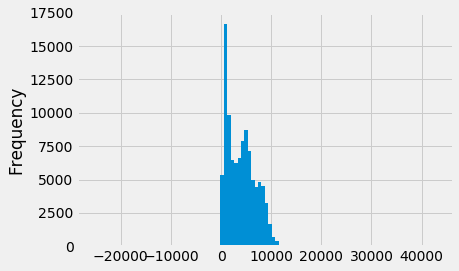

In [67]:
ax = data.loc[:, 'Field_7'].plot(kind='hist', bins=100)


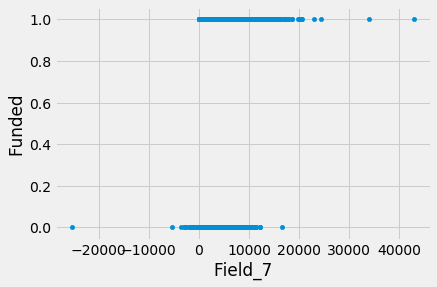

In [68]:
data.plot(kind='scatter', x='Field_7', y='Funded');

Again seeing broader range for funded than unfunded observations  
Cluster seems to be higher for funded than for unfunded

##  
##  
## Recap and next steps

The overall dataset is pretty clean, there are no missing or blank values.

Some of the categorical variables are unbalanced, which will need to be re-evaluated, and either modified or dropped.  

One potential shortcoming is how little explanatory power form presence had over the funded variable, which could be problematic. However, it's possible the regression tree will identify relationships that were not immediately obvious on the rough overview correlation matrix I generated. Also, I only included 30 of the most popular forms, there could be less popular forms with greater predictive power. 

This is the simple version, as the model gets built out, would like to add in more forms (up to 150 are available), and also pull in a larger data set (1.7M observations available, currently only looking at a random sample of 100k).